# Light GCN Sample Notebook

## 0. Env Preparation

### 0.1 Install Packages

In [ ]:
!pip install ipywidgets
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cu116.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cu116.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

### 0.2 Import Packages

In [4]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

Check our environment

In [5]:
torch_geometric.__version__

'2.1.0'

Set device for torch

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Data Processing

### 1.1 Read Data

To keep the notebook as simple as possible, we only consider three columns: place_index, user_index, and rating.


In [7]:
columns_name = ['place_index', 'user_index', 'rating']
review_df = pd.read_csv("../competition-data/train.tsv", sep="\t")[columns_name].astype(int)

### 1.2 Number of User and Place

In [8]:
num_user = len(review_df['user_index'].unique())
num_place = len(review_df['place_index'].unique())

### 1.3 Split Data

In [9]:
# It is possible some users or restaurants in test do not exist in 
# train after this split.
# Will need to retrain the model with combined train+test after picking
# the best model structure
train, test = train_test_split(review_df.values, test_size=0.1)
train_df = pd.DataFrame(train, columns=review_df.columns)
test_df = pd.DataFrame(test, columns=review_df.columns)

### 1.4 Dataset and Dataloader

In [10]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data.to_numpy()
        
    def __getitem__(self, index):
        return self.data[index, 0], self.data[index, 1], self.data[index, 2:3].astype(np.float32)
    
    def __len__(self):
        return len(self.data)

train_dataset = MyDataset(train_df)
test_dataset = MyDataset(test_df)

## 2. Graph Construction

A graph is defined as a set of nodes and edges. In our case, we can simply treat users and restaurants as nodes in graphs, and the interaction between user and restaurant (i.e. the review users give to restaurants) as edges.

We also refactor `user_index` and `place_index` to node indices. Currently both `user_index` and `place_index` start from 0, so we add `num_user` to all place indices, so that `user_index` and `place_index` are in the same space and don't overlap.

We then construct edge indices by connecting every user to one's reviewed restaurants, and every restaurant to its reviewers, or more formally

$$\mathbf{E} = \bigcup_{(u_i, r_i)}\{(u_i, r_i), (r_i, u_i)\}$$

You will see in following training section, how this edge indices are used. You are welcome to make edits to graph construction to improve model prediction.

In [23]:
u_t = torch.LongTensor(train_df.user_index.to_numpy())
p_t = torch.LongTensor(train_df.place_index.to_numpy()) + num_user

train_edge_index = torch.stack((torch.cat([u_t, p_t]),torch.cat([p_t, u_t]))).to(device)

## 3. Model Architecture

First, let's take a look at the graph convolutional layers that will power our recommender system GNN. Then, we can implement a wrapper to stack multiple convolutional layers.

### 3.1 LightGCN Convolutional Layer

The LightGCN architecture is governed by the following rules:

$$e_{u}^{(k+1)} = \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}e^{(k)}_i$$

$$e_{i}^{(k+1)} = \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}e^{(k)}_u$$
In essence, the embedding for each node after a single LightGCN layer is the sum of the synthetic normalized embeddings of it's neighbors before the layer.

An example to illustrate how it works is appended below. Check it out!

Here we use MessagePassing layer from PyG (PyTorch Geometric), which we installed in the beginning of this notebook. For more information about using this package, check the very nice tutorial on their website: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html.

A MessagePassing layer, as it inherits from pytorch `nn.Module` class, is called with `forward` function, as we will later see. The special feature of graph learning in MessagePassing layer happens in `propagate` function. There are typically three steps happening in `propagate`:

1. **message**
This function defines what message we want to pass from a node to another. In the following example, we simply pass the node embedding of a user node or a restaurant node to its neighbors, but you can add more information to it. For example, a user node can also let its' neighbors know what the average rating a user gives.

2. **aggregate**
When the node receives messages from its neighbors (sent by `message()` function), there are different ways to aggregate the messages. For example, we can simply add all the messages together (assume that the messages are already normalized). Or we can calculate the average, or pick element-wise max values, etc. This is like pooling layers in a traditional Convolutional Neural Network.

3. **update**
After aggregating the messages collected from neighbors, we will need to update the embedding of current node. By default we update the nodes with aggregation results. But there's always space for creativity.

You may override each of the three methods above, to define your own behaviors.


In the following example, we defined our own `message` function. We multiply the current node embedding with the normalization coefficient to get the message we want the node to send to its' neighbors.



We can specify the type of aggregation our `MessagePassing` layer should use by passing in an `aggr=` argument in the layer initialization. Here we use `add` to specify summation aggregation of messages.

Note that we could have manually defined our aggregation function by defining a function explicitly in the class:
```
def aggregate(self, x, messages, index):
  return torch_scatter.scatter(messages, index, self.node_dim, reduce="sum")
```
The `torch_scatter.scatter` function enables us to aggregate messages being sent to the same node. The `reduce=` argument specifies how to aggregate, while `index` has the same length as the `messages` tensor and maps from message to destination node.

In [12]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
        # Compute normalization
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]
        # Start propagating messages (no update after aggregation)
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

Let's see how our implementation of the LightGCN convolution by applying it to a small bipartite graph.

This sample graph is undirected, and node 0 is connected to nodes 2 and 3 while node 1 is connected to 3 and 4. Imagine that as, node 0 is a user who reviewed restaurants node 2 and node 3. Node 1 is another user who reviewed restaurant node 3 and node 4.

The following image shows the graph, and labels the process how embedding of node 0 is updated.

![GCN sample](https://drive.google.com/uc?export=view&id=13-LiDY5Gftj4UfbT_QVrr419dFaop1MY)

In [27]:
# Initialize node embeddings as one-hot embeddings
test_x = torch.Tensor(np.eye(5))

# Construct edges
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

# Check out the result of passing the embeddings through our Graph Convolutional Network
LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

### 3.2 Recommender System GNN

Next we embed the LightGCN layer into a full neural network.

In `pred` function, we concatenated user embedding and restaurant embedding that we are interested in, and predict the ratings based on the embeddings.

In [34]:
class LightGCN(nn.Module):
    def __init__(self, latent_dim, num_layers, num_users, num_items):
        super(LightGCN, self).__init__()
        self.embedding = nn.Embedding(num_users + num_items, latent_dim)
        self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))
        self.init_parameters()
        self.nn1 = nn.Linear(2*latent_dim, 2*latent_dim)
        self.nn2 = nn.Linear(2*latent_dim, 1)

    def init_parameters(self):
        nn.init.normal_(self.embedding.weight, std=0.1) 

    def forward(self, edge_index):
        emb0 = self.embedding.weight
        embs = [emb0]
        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = torch.mean(torch.stack(embs, dim=0), dim=0)
        return emb0, out
    
    def pred(self, users, items, embeddings):
        user_emb = embeddings[users]
        item_emb = embeddings[items]
        x = torch.cat((user_emb,item_emb), 1)
        x = self.nn1(x)
        x = self.nn2(x)
        return x

## 4. Train and evaluate models

Set Parameters

In [35]:
latent_dim = 64
n_layers = 3 

EPOCHS = 5
BATCH_SIZE = 32
DECAY = 0.0001
LR = 0.005 
K = 2

Set Model

In [36]:
lightgcn = LightGCN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=num_user,
    num_items=num_place,
)
lightgcn = lightgcn.to(device)

Set Train Function

In [45]:
def get_testset_loss(model, testset, loss_fn, embeddings):
    loss_list = []
    with torch.no_grad():
        for users, items, ratings in DataLoader(testset, batch_size=BATCH_SIZE):
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            pred = model.pred(users, items, embeddings)
            loss = loss_fn(pred, ratings)
            
            loss_list.append(loss.item())
            
    return sum(loss_list) / len(loss_list)


def train(model, optimizer, train_dataset, n_users, n_restaurants, train_edge_index, loss_fn):
    loss_list_epoch = []
    valid_loss_list_epoch = []
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    min_valid_loss = None
    min_loss_model = None
    for epoch in tqdm(range(EPOCHS)):
        n_batch = int(len(train_dataset)/BATCH_SIZE)
        loss_list = []
        model.train()
        for users, items, ratings in tqdm(train_dataloader):
            optimizer.zero_grad()
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            _, embeddings = model(train_edge_index)
            pred = model.pred(users, items, embeddings)
            loss = loss_fn(pred, ratings)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            
        # evaluate on validation data
        valid_loss = get_testset_loss(model, test_dataset, loss_fn, embeddings)
        if min_valid_loss is None or valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            min_loss_model = torch.save(model.state_dict(), f"epoch_{epoch}.ckpt")
            
        valid_loss_list_epoch.append(round(valid_loss, 4))
        loss_list_epoch.append(round(np.mean(loss_list),4))

    return loss_list_epoch, valid_loss_list_epoch

Set Loss and Optimizer

In [46]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)

Train the Model

In [47]:
loss_history, valid_loss_history = train(lightgcn, optimizer, test_dataset, num_user, num_place, train_edge_index, loss_function)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4219 [00:00<?, ?it/s]

  0%|          | 0/4219 [00:00<?, ?it/s]

  0%|          | 0/4219 [00:00<?, ?it/s]

  0%|          | 0/4219 [00:00<?, ?it/s]

  0%|          | 0/4219 [00:00<?, ?it/s]

Plot the Loss

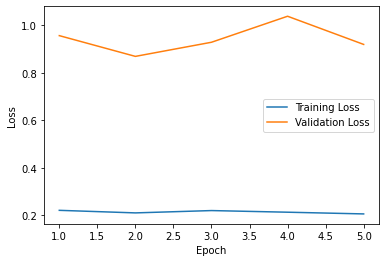

In [48]:
epoch_list = [(i+1) for i in range(EPOCHS)]

plt.plot(epoch_list, loss_history, label='Training Loss')
plt.plot(epoch_list, valid_loss_history, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## 5. Prepare for submission

As we have already saved the best model checkpoint above, we now only need to refactor the current notebook into a runnable python script, and generate a .tsv file containing prediction results.

In [58]:
blind_test_data = pd.read_csv("../competition-data/test_leaderboard-input.tsv", sep='\t')
blind_test_data = blind_test_data[['user_index', 'place_index']] # keep only consummable columns
blind_test_dataset = MyDataset(blind_test_data)

# All nodes and indices in blind test have already appeared in training data, 
# so we can re-use the same edge-index
model = LightGCN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=num_user,
    num_items=num_place,
)
model = model.to(device)
model.load_state_dict(torch.load('./epoch_1.ckpt'))  # replace the checkpoint file with the best candidate
_, embeddings = model(train_edge_index)

predictions = []

with torch.no_grad():
    for users, items, _ in DataLoader(blind_test_dataset, batch_size=BATCH_SIZE):
        users, items = users.to(device), items.to(device)
        pred = model.pred(users, items, embeddings)
        predictions += list(pred.cpu())
        
predictions = [pred.item() for pred in predictions]
blind_test_data['prediction'] = predictions

blind_test_data[['prediction']].to_csv('predictions.csv', index_label='Id')